# Assignment 4
## Lercio headlines generator

Implementation and training of a character based RNN in pytorch to generate headlines in the style of the satirical news website [Lercio](https://www.lercio.it/).

### Environment setup and execution instructions
The project depends on the following libraries:

- pytorch: ML library for python
- unidecode: used to convert unicode characters to the closest ASCII representation
- tqdm: used to display progress bars
- matplotlib: loss graph plotting

The project is contained in a single jupyter notebook, all dependencies are installed automatically (except for pytorch, which is present in Colab but must be installed manually in a local environment).
Some pretrained models are downloaded automatically to show the results.

The `EXECUTE_TRAINING` flag can be used to disable training and only load the pre-trained models.

If the training results in a CUDA out-of-memory error, the batch size can be reduced by increasing the value of `splits`

In [1]:
EXECUTE_TRAINING = False

# Comment if running locally
!pip install unidecode tqdm matplotlib 
!rm models.zip
!wget --no-check-certificate https://raw.githubusercontent.com/iannisimo/UniPi_ISPR_Mid3/main/models.zip
!unzip models.zip -y

# Uncomment if running locally
# %pip install --upgrade jupyter ipywidgets unidecode tqdm matplotlib

# If local, run this command after installing the requirements (to enable tqdm widget to work properly)
# jupyter nbextension enable --py widgetsnbextension

!rm lercio_headlines.csv
!wget --no-check-certificate https://elearning.di.unipi.it/pluginfile.php/46562/mod_assign/intro/lercio_headlines.csv

--2023-05-12 13:41:46--  https://raw.githubusercontent.com/iannisimo/UniPi_ISPR_Mid3/main/models.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10290202 (9.8M) [application/zip]
Saving to: ‘models.zip’

models.zip          100%[===================>]   9.81M  3.61MB/s    in 2.7s    

2023-05-12 13:41:50 (3.61 MB/s) - ‘models.zip’ saved [10290202/10290202]

Archive:  models.zip
caution: filename not matched:  -y
--2023-05-12 13:41:50--  https://elearning.di.unipi.it/pluginfile.php/46562/mod_assign/intro/lercio_headlines.csv
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving elearning.di.unipi.it (elearning.di.unipi.it)... 131.114.23.133
Connecting to elearning.di.unipi.it (elearn

### Model definition

The model was somewhat inspired by the **Char-RNN** [https://github.com/spro/char-rnn.pytorch](https://github.com/spro/char-rnn.pytorch) implementation.
It is a simple RNN module based on GRU cells. It takes as input a batch of characters (encoded as one-hot vectors), passes them through `n_layers` layers of GRU, and after a fully connected layer, outputs a probability distribution over the characters (SoftMax).

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, dropout = 0):
        super(CharRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.rnn = nn.GRU(input_size, hidden_size, n_layers, dropout=dropout, batch_first=True).to(DEVICE)
        self.fc = nn.Linear(hidden_size, output_size).to(DEVICE)
        self.softmax = nn.LogSoftmax(dim=2).to(DEVICE)
        self.losses = None

    def forward(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        output = self.fc(output)
        output = self.softmax(output)
        return output, hidden

    # Initialize hidden state (used before forward pass for each mini-batch)
    def init_hidden(self, batch_size):
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)).to(DEVICE)

### Data loading and preprocessing

The data is loaded from the CSV, treating each row as a separate headline. In order to remove special characters, each line is passed through unidecode, which takes the raw text and returns a string with all non-standard characters replaced with their closest standard equivalent.
Then a dictionary `vocab` is created, mapping each character to a unique index.

In [3]:
from unidecode import unidecode

def readLines(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        return [unidecode(line) for line in f]
    
# Read the list of headlines from the csv
headlines = readLines('./lercio_headlines.csv')
headlines = sorted(headlines, key=len, reverse=True)

# Create a list of all the unique letters in the headlines
all_letters_list = list(set(''.join(headlines))) + ['✕']
all_letters_list.sort()
all_letters = ''.join(all_letters_list)
num_letters = len(all_letters)

# Create a dictionary mapping each letter to the corresponding index in the list of all letters
vocab = {all_letters[i]: i for i in range(num_letters)}

### Input tensors creation

In order to speed up training, a batched approach is used. Since the headlines sequences are of different lengths, the sequences are padded with a special character `✕` not present in the text. As a result of this, two important tensors are created: `headlines_tensor` and `headlines_one_hot`:
- `headlines_tensor` is a tensor of shape `(batch_size, max_headline_length)`, containing the indices of the characters in the headlines.
- `headlines_one_hot` is a tensor of shape `(batch_size, max_headline_length, vocab_size)`, containing the one-hot encoding of the characters in the headlines.
The first one is needed in order to compute the loss, while the second one is needed as input to the model.

In [4]:
# Convert headlines to tensors of character indices (vocab)
headlines_tensor_list = [torch.tensor([vocab[letter] for letter in headline]) for headline in headlines]
# Pad headlines tensor to common length
headlines_tensor = nn.utils.rnn.pad_sequence(headlines_tensor_list, batch_first=True, padding_value=vocab['✕']).to(DEVICE)
# Convert the padded dataset to one-hot encoding
headlines_one_hot = nn.functional.one_hot(headlines_tensor, num_classes=num_letters).to(torch.float32).to(DEVICE)

### Sampling

Two sampling methods are implemented: `generate` and `generate_normal`
- `generate` is just given a starting string and a single temperature value and keeps generating characters until it reaches `max_len` characters or the stop character `\n` is encountered.
- `generate_normal` is given instead a starting string, and two parameters `mean_temp` and `std_temp`; for each character, the temperature is sampled from a normal distribution. The generation stops with the same criteria as before.

In [5]:
import numpy as np

# Given a line of text, convert it to the respective one-hot encoding
def input_to_onehot(line):
    return nn.functional.one_hot(torch.tensor([vocab[c] for c in line]), num_letters).to(torch.float32).to(DEVICE).view(1, -1, num_letters)

@torch.no_grad()
def generate(model, start_string, temperature = 1, max_len = 200):
    input = input_to_onehot(start_string)
    hidden = model.init_hidden(1)

    output_name = start_string

    for j in range(input.shape[1] - 1):
        output, hidden = model(input[:, j, :].view(1, 1, num_letters), hidden)
    for i in range(max_len):
        output, hidden = model(input[0, -1].view(1, 1, num_letters), hidden)
        if temperature == 0:
            topi = output.data.view(-1).argmax()
        else:
            output_dist = output.data.view(-1).div(temperature).exp()
            topi = torch.multinomial(output_dist, 1)[0]
        if topi == all_letters.find('\n'):
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = input_to_onehot(letter)

    return output_name

@torch.no_grad()
def generate_normal(model, start_string, mean_temp = 0, std_temp = 0, max_len = 200):
    input = input_to_onehot(start_string)
    hidden = model.init_hidden(1)

    output_name = start_string

    for j in range(input.shape[1] - 1):
        output, hidden = model(input[:, j, :].view(1, 1, num_letters), hidden)
    for i in range(max_len):
        output, hidden = model(input[0, -1].view(1, 1, num_letters), hidden)

        temperature = np.random.normal(mean_temp, std_temp)
        temperature = abs(temperature)

        # Since a too-low temperature would result in an exception given by limited numerical precision, this piece of code is encapsulated in a try-except block which handles the exception by getting the most probable character without temperature. 
        try:
            output_dist = output.data.view(-1).div(temperature).exp()
            topi = torch.multinomial(output_dist, 1)[0]
        except RuntimeError:
            topi = output.data.view(-1).argmax()
        if topi == all_letters.find('\n'):
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = input_to_onehot(letter)

    return output_name

### Training

The model is trained using the Adam optimizer, with a starting learning rate of 0.01. A scheduler is used to decrease the learning rate as the training proceeds. 

The loss is computed using the `NLLLoss` function, using the `ignore_index` parameter set to the padding character (without this the model often would get stuck ouputting only padding chars).

In order to fit the model in the GPU memory, the full set of headlines is split into mini-batches.

Gradient clipping is used in order to mitigate some loss spikes.

#### Training loop
The key points of the training loop are:
- The headlines are split in `splits` mini-batches. For each one:
    - The hidden states are initialized.
    - The loss (for the MB) is reset.
    - For each character of the sequences:
        - The model is fed the current character and the hidden states.
        - The loss is computed and added to the sum of losses.
    - The gradients are computed and clipped.
    - The optimizer is updated. (adam)
- The average loss for the epoch is computed.
- The scheduler is updated (learning rate).

Every 50 epochs, some sample headlines are generated and printed.

#### Results

It was found empirically that an optimal loss value is `~0.15`. Above this value, the generated phrases are often not readable, while below this value the model tends to overfit and generate only phrases from the training set.

In [6]:
import string
import random
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
upper = string.ascii_uppercase

# If no training requested, skip the cell
if EXECUTE_TRAINING:

    # Remains of the teacher forcing tests
    # TFR_TARGET = 0.15
    # TFR_MAX = 1
    # TFR_MIN = 0.8

    # Gradient clipping value
    CLIPPING = 0.1

    padding = torch.tensor([vocab['✕']], device=DEVICE)

    epochs = 1000
    splits = 5

    PARAM = {
        'HIDDEN_SIZE': 250,
        'N_LAYERS': 2,
        'DROPOUT': 0
    }


    losses = []
    HIDDEN_SIZE = PARAM['HIDDEN_SIZE']
    N_LAYERS    = PARAM['N_LAYERS']
    DROPOUT     = PARAM['DROPOUT']
    base_name = f'H{HIDDEN_SIZE}_N{N_LAYERS}_D{DROPOUT:.2f}_'

    rnn = CharRNN(num_letters, HIDDEN_SIZE, num_letters, N_LAYERS, DROPOUT).to(DEVICE)
    criterion = nn.NLLLoss(ignore_index=vocab['✕'])

    # Initialize optimizer and lr scheduler with 0.01 initial lr, linear decay for 500 epochs up to 0.0001, then constant for the rest
    decoder_optimizer = torch.optim.RAdam(rnn.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.LinearLR(decoder_optimizer, 1, 0.01, 500)

    one_hot = headlines_one_hot

    try:
        tfr = 1
        for epoch in tqdm(range(epochs), total=epochs):
            loss_perms = []
            # Split the data into `split` parts and train on each part
            perms = np.array_split(np.random.permutation(one_hot.shape[0]), splits)
            for perm in perms:
                input_tensor = one_hot[perm, :-1, :]
                output_tensor = headlines_tensor[perm, 1:]
                perm_size = input_tensor.shape[0]
                hidden = rnn.init_hidden(perm_size)
                rnn.zero_grad()

                loss = 0
                character_tensor = input_tensor[:, 0:1, :]
                # Send sequience through the network one character at a time
                for c in range(input_tensor.shape[1]):
                    output, hidden = rnn(character_tensor, hidden)
                    # Since `criterion` is ignoring the padding character, once all the characters in the mini-batch are padding, the loss would be NaN.
                    # To avoid this, we set the loss to 0 manually.
                    if (output_tensor[:, c:c+1] == padding).all():
                        l = 0
                    else:
                        l = criterion(output.mT, output_tensor[:, c:c+1])
                    loss += l
                    # Teacher forcing (not used, always TRUE)
                    if random.random() < tfr:
                        character_tensor = input_tensor[:, c+1:c+2, :]
                    else:
                        character_tensor = output
                # Average the loss over the sequence length
                loss /= input_tensor.shape[1]
                    
                # Backpropagate and clip gradients
                loss.backward()
                torch.nn.utils.clip_grad_norm_(rnn.parameters(), CLIPPING)

                decoder_optimizer.step()
                loss_perms.append(loss.data.item())
            loss_epoch = np.mean(loss_perms)
            losses.append(loss_epoch)
            scheduler.step()
            # tfr = min(1, TFR_MIN + (TFR_MAX - TFR_MIN) * (loss / TFR_TARGET))

            # Every 50 epochs, generate some samples
            if epoch % 50 == 49:
                print(f'Epoch: {epoch},\tloss: {loss_epoch}')
                start = random.choice(upper)
                print(f'T: 0.05  S: {generate(rnn, start, 0.05)}')
                print(f'T: 0.1   S: {generate(rnn, start, 0.1)}')
                print(f'T: 0.2   S: {generate(rnn, start, 0.2)}')
                print(f'T: .7±.4 S: {generate_normal(rnn, start, .7, .4)}')
    except KeyboardInterrupt:
        print('Interrupted')
    finally:
        # Once the training is done (or interrupted), save the model
        print('Saving model')
        model_name = f'H{HIDDEN_SIZE}_N{N_LAYERS}_D{DROPOUT:.2f}_E{epoch}_L{loss_epoch:.2f}_rnn.pt'
        rnn.losses = losses
        torch.save(rnn, model_name)

### Sampling

This cell picks every model saved to disk (workspace dir, <name>_rnn.pt) and generates some headlines for each uppercase letter of the alphabet at different temperature values.

The sampling is done using both the `generate` and `generate_normal` functions.
Each UPPERCASE letter of the alphabet is used as a starting character, and the headlines are generated with both methods, and different parameters. 


################## H350_N2_D0.00_E999_L0.06_rnn.pt ##################

------ A ------
T: 0       S: Anziano seduto davanti al marciapiede di casa festeggia la milionesima macchina contata
T: 0.1     S: Anziano seduto davanti al marciapiede di casa festeggia la milionesima macchina contata
T: 0.5     S: Angelina Jolie si fa rimuovere il piano: ordinatesti mo di Windon Antria
T: 0.7     S: Anziano di venerginiti: a 100 anni paga in ariati per far se la sostituzione del panito
T: 0.9     S: Adinolfi videllente barne di pansione solo le tasso deserta die ricossi con le scorge
T: 0±.4    S: Alberto Angela disperso durante puntata di "Ulisse" dedicata alle buche di Roma
T: 0.5±.4  S: Allarme sicurezza negli aeroporti: impreparati contro pistole di marzapane
T: 1±.7    S: Alfano risposta a prendere "Se" il Letter yotube in tuzza scorroggieta"
------ B ------
T: 0       S: Berlusconi annuncia un suo imminente annuncio
T: 0.1     S: Berlusconi si addormenta durante un pompino
T: 0.5     S: Br

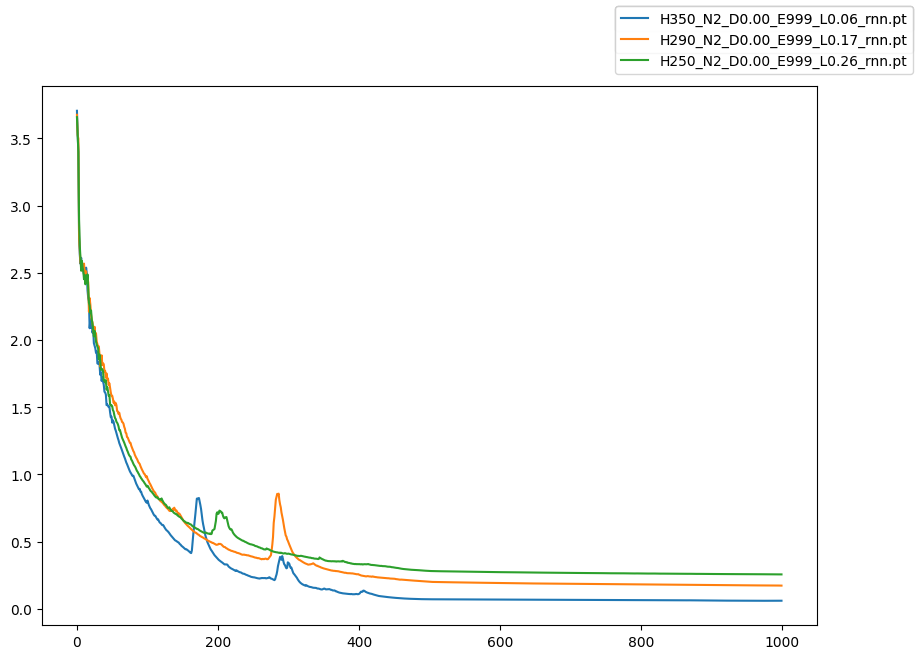

In [7]:
from matplotlib import pyplot as plt

models = [x for x in Path('.').iterdir() if '_rnn.pt' in str(x)]
fig, ax = plt.subplots(figsize=(10, 7))

for model in models:
    rnn = torch.load(model)
    rnn.train(False)

    ax.plot(rnn.losses, label=model)
    fig.legend()

    print(f'\n################## {model} ##################\n')

    for U in upper:
        print(f'------ {U} ------')
        print(f'T: 0       S: {generate(rnn, U, 0)}')
        print(f'T: 0.1     S: {generate(rnn, U, 0.1)}')
        print(f'T: 0.5     S: {generate(rnn, U, 0.5)}')
        print(f'T: 0.7     S: {generate(rnn, U, 0.7)}')
        print(f'T: 0.9     S: {generate(rnn, U, 0.9)}')
        print(f'T: 0±.4    S: {generate_normal(rnn, U, 0, 0.4)}')
        print(f'T: 0.5±.4  S: {generate_normal(rnn, U, 0.5, 0.4)}')
        print(f'T: 1±.7    S: {generate_normal(rnn, U, 1, 0.7)}')

### Results

Above are shown some phrases generated with different models and at different temperatures.
Also shown are the loss curves for each one.

The impact of dropout is not shown as I was not able to train a model with dropout which did not underfit.

From the loss curves, it can be seen that there are some spikes. The situation was much worse before the implementation of gradient clipping and the scheduling of the learning rate (to the point that before that, this results were unimaginable).

##### H350_N2_D0.00_E999_L0.06_rnn.pt

This model was trained with an hidden size of 350 and 2 layers. The final loss was 0.06.
As can be seen, at low temperatures, the model outputs only phrases from the training set, while at higher temperatures it tends to generate less readable phrases. The `generate_normal` does not seem to improve the results.

Examples:
- T: 0       S: Berlusconi annuncia un suo imminente annuncio
- T: 0±.4    S: Berlusconi affidato a un centro anziani: "Organizzero delle tombolate eleganti"
- T: 0       S: Giovane muore di vecchiaia
- T: 0.7     S: Grandi cambiamenti in Trenitalia: la linea gialla diventera azzurrina

    

##### H250_N2_D0.00_E999_L0.26_rnn.pt

This model was trained with an hidden size of 250 and 2 layers. The final loss was 0.26.
In this case, the vast majority of the generated phrases have no meaning whatsoever.
At low temperature the phrases are mostly composed of real words but with no meaning in their order, while at higher temperatures the generated words are mostly gibberish.

Examples:
- T: 0       S: Mario Roga serie alle fredi e scopre che il proiettoli di Massimo Boldi
- T: 0.5     S: Milano. Maggio confessa: "Mi sono commolone dalla mano se piatta festa a meta dei camono"
- T: 0.1     S: Ricerca rivela: "Sono sbarto per un famma dal senza dell'azioni"
- T: 0±.4    S: Ricerca rivela: "Sono sciopero da Raina perche non che ha veterricano sulla Lottare"


##### H290_N2_D0.00_E999_L0.17_rnn.pt

This one is a decent tradeoff between the others. It was trained with an hidden size of 290 and 2 layers. The final loss was 0.17.
In the generated phrases, it is possible to find some phrases from the training set (mostly at low temperatures), and some nonsensical phrases.
However, it is still possible to see some (roughly) correct phrases which are not present in the training set.

Examples:
- T: 0.1     S: Facebook introduce il primo figlio contro i pedaliri
- T: 0.5±.4  S: Facebook costretta a pubblicare milioni di sinistra per anziani
- T: 0.1     S: Papa Francesco canonizza contemporane a una giorna di agolienti funzioni
- T: 0.5±.4  S: Primarie PD a Napoli. Galea cambia il dentista in vacanza in Elsa Cappellann

### Conclusions

One big limiting factor of this model is the lack of a metric for evaluation: some candidates could be:
- The loss on a validation set (given the small size of the dataset and the high diversity in the headlines, I was not able to implement this properly)
- Proportion of generated words present in a dictionary; this however would not take into account the order of the words.
- A carefully crafted metric which would `reward` known (good) sequences of words while penalizing blatant copies of the training set in order to avoid overfitting.
- A human evaluation; which is roughly what I did, but it is not very reliable.

It is easy to see how the start of the phrases is often _pulled_ from the dataset, while the end starts to diverge from it.

### Funny results

During the training, I saved the headlines which made me giggle. Here are some of them:

_Di Maio rivela: "Sono solo solo solo solo con le parte di parte di Barkandi"_ (To read in the style of a Marco Mengoni's song)

_La Chiesa apre ai matrimoni tra omosessuali di m***a_ (Like every good model, even mine had to be somewhat offensive, see Meta's BlenderBot3 racism scandal from Aug. 2022)

_Trovato il gatto che ha mangiare i dati 1.008"_ (The cat has eaten the data mid sentence, breaking the model)

_LercioNews a Radio2 Social Club - 36 ottobre 2015_ (Apparently October has 36 days now)

_Washington: estremista testimone di Geova che non parla inculittiva clandestini_ (This one was almost there)

_Berlusconi scopre che andra al suo post di condominio del PD si arrende_ (this too)